# Equality Data - Analysis & Index construction
***

In [68]:
# Imports
import numpy as np
import pandas as pd

import seaborn as sns

# Pandas display settings
pd.set_option("display.max_rows", 110)
pd.set_option("display.max_columns", 30)

pd.set_option("display.precision", 2)

In [69]:
# Load Data
gsheet_id = "1cgDCPSHxYLbeNpE-UIocjOXYMtlk4tZwYsUsVchJFCI"
sheet_may = "March%20data%20(2020)"
sheet_june = "June%20data%20(2020)"

df_march = (pd.read_csv(
    f"https://docs.google.com/spreadsheets/d/{gsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_may}")
    .iloc[:, :22] # Trim extra empty columns
    .set_index("Company "))

df_june = (pd.read_csv(
    f"https://docs.google.com/spreadsheets/d/{gsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_june}")
    .iloc[:, :22] # Trim extra empty columns
    .set_index("Company "))

## Cleaning
***

### **Comparing March and June datasets**
- The June and March datasets have a slightly different list of companies, so this is actually an index of 103 companies when the two are combined

In [70]:
# Get companies
june_companies = df_june.index.values
march_companies = df_march.index.values

# Find companies that are in June but not March and vice versa
june_only = june_companies[np.isin(june_companies, march_companies, invert=True)]
march_only = march_companies[np.isin(march_companies, june_companies, invert=True)]

print(f"Companies in June dataset only: {june_only}")
print(f"Companies in March dataset only: {march_only}")

print(f"{len(np.unique(np.concatenate([june_companies, march_companies])))} total companies")

Companies in June dataset only: ['Avast' 'GVC Holdings' 'Homeserve' 'Kingfisher']
Companies in March dataset only: ['Carnival Corporation & plc' 'Centrica' 'easyJet plc' 'Meggitt plc']
103 total companies


In [71]:
# June and March dataset look broadly similar in terms of missing values
# Although there are a few less gaps in March

total_companies = 99

data_gaps = (pd.concat(
    [df_june.isnull().sum()/total_companies, df_march.isnull().sum()/total_companies], axis=1)
    .rename(columns={0: "June NaNs %", 1: "March NaNs %"}))


cm = sns.light_palette("red", as_cmap=True)
data_gaps.style.background_gradient(cmap=cm)

,June NaNs %,March NaNs %
Most recent graduate intake who are female (%),0.71,0.70
Senior manageers who are female (%),0.06,0.08
Employees who are female (%),0.02,0.01
"Length of primary parental leave, fully-paid",0.52,0.49
"Length of secondary parental leave, fully-paid",0.60,0.59
Gender pay gap (%),0.13,0.12
Gender pay gap improvement (% change),0.15,0.13
Gender bonus pay gap,0.15,0.14
Directors who are female (%),0.00,0.00
New directors appointed who are female (%),0.01,0.00


## Percentage changes between March and June datasets
Lets compare the March and June datapoints (where values exist for both months)

**Observations**
- The difference between March and June datapoints are generally small (or none), with some exceptions e.g. Barret Developments Gender Pay Gap jumping from 3.2% to 34.2%
- "Directors who are female (%)" and "New directors appointed who are female (%)" both have unexpectedly dramatic % changes. This is because of a discrepancy in the datasets - for March, the figures are percentages while for June they are decimals

In [72]:
# Lets compare March and June datasets in terms of percentage changes

df_combined = pd.concat([df_march, df_june])
df_pct_change = df_combined.groupby(level=0).agg(
    lambda x: x[-1] - x[0]) # Substract March value from June value

cm = sns.color_palette("vlag", as_cmap=True)
df_pct_change.style.background_gradient(cmap=cm,  vmin=-50, vmax=50, axis=None)

,Most recent graduate intake who are female (%),Senior manageers who are female (%),Employees who are female (%),"Length of primary parental leave, fully-paid","Length of secondary parental leave, fully-paid",Gender pay gap (%),Gender pay gap improvement (% change),Gender bonus pay gap,Directors who are female (%),New directors appointed who are female (%),WISE membership,Level of WISE membership,Employees who are BAME (%),BAME pay gap (%),Senior managers who are BAME (%),Employees who are LGBT+ (%),LGBT+ pay gap (%),Senior managers who are LGBT+ (%),Employees disclosed as disabled (%),Disability pay gap (%),Senior managers disclosed as disabled (%)
Company,,,,,,,,,,,,,,,,,,,,,
3i,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,39.67,99.50,0,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
Admiral Group,nan,5.00,0.00,0.00,0.00,0.90,-1.20,4.80,36.10,24.50,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
Anglo American plc,nan,0.00,0.00,nan,nan,0.00,0.00,0.00,27.03,39.80,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
Antofagasta,nan,nan,1.00,nan,nan,nan,nan,nan,19.82,-0.50,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
Ashtead Group,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,37.12,19.57,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
Associated British Foods,nan,0.00,0.00,nan,nan,0.00,0.00,0.00,24.75,0.00,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
AstraZeneca,nan,0.80,-0.10,nan,nan,0.00,0.00,0.00,49.64,74.40,0,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
Auto Trader Group,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,49.57,66.03,0,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
Avast,nan,0.00,0.00,nan,nan,nan,nan,nan,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### **Combine March and June datasets**
There are a number of different ways we could combine the June and March dataset into a single dataset 
- If this is a "live" index (e.g. gets updated once a month or even more frequently), it would make sense to primarily use the June dataset as representing the most up-to-date data, and only use the March data to forward-fill where data for June does not exist
- If this is a one-off index, or something that is only updated yearly, it might make more sense to average between months, particularly if some indicators vary significantly over time

For this project, I've kept things simple and used the first approach, using data-points from March to fill in missing values in June only. I haven’t done anything to change the March values, like trying to predict changes/forecast trends from March to June as the time difference is relatively small

In [73]:
# First, let's fix those two columns mentioned earlier with the decimal inconsistency 
df_march["New directors appointed who are female (%)"] = df_march["New directors appointed who are female (%)"] * 100
df_march["Directors who are female (%)"] = df_march["Directors who are female (%)"] * 100


In [220]:
def ffill(x: pd.Series) -> float:
    """ 
    Forward-fill data from older dates where most recent datapoint
    doesn't exist 
    """
    if np.isnan(x.iloc[-1]): # If June data is NaN...
        val = x.iloc[0] # Use May
    else:
        val = x.iloc[-1] # Else use June
    return val

df_combined = pd.concat([df_march, df_june])
df = df_combined.groupby(level=0).agg(
    lambda x: ffill(x))

df.head()

,Most recent graduate intake who are female (%),Senior manageers who are female (%),Employees who are female (%),"Length of primary parental leave, fully-paid","Length of secondary parental leave, fully-paid",Gender pay gap (%),Gender pay gap improvement (% change),Gender bonus pay gap,Directors who are female (%),New directors appointed who are female (%),WISE membership,Level of WISE membership,Employees who are BAME (%),BAME pay gap (%),Senior managers who are BAME (%),Employees who are LGBT+ (%),LGBT+ pay gap (%),Senior managers who are LGBT+ (%),Employees disclosed as disabled (%),Disability pay gap (%),Senior managers disclosed as disabled (%)
Company,,,,,,,,,,,,,,,,,,,,,
3i,50.0,23.7,40.0,18.0,6.0,NaN,NaN,NaN,40.0,100.0,0,0.0,12.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Admiral Group,NaN,34.0,51.0,16.0,2.0,4.5,-0.9,29.7,36.4,25.0,0,0.0,6.07,NaN,NaN,9.35,NaN,NaN,2.83,NaN,NaN
Anglo American plc,NaN,24.0,21.0,NaN,NaN,41.0,8.0,78.0,27.3,40.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Antofagasta,NaN,21.0,10.0,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ashtead Group,14.0,13.8,9.6,NaN,NaN,-1.3,-0.4,-37.1,37.5,20.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA
***
### **Visualise distribution of each indicator**

I visualised the distribution of each indicator to get a clearer view of what was going on (results in `/graphics`)

- The indicators essentially look mostly as expected - they are either continuous percentages or percentage changes
- "WISE Membership" is binary
- "Level of WISE membership" is ordinal
- "Gender bonus pay gap" has a long left-tail, which required some transformation for normalisation later (There were other indicators with tails but this one was the most extreme)

/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 67 rows containing non-finite values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 67 rows containing missing values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 4 rows containing non-finite values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 4 rows containing missing values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 1 rows containing missing valu

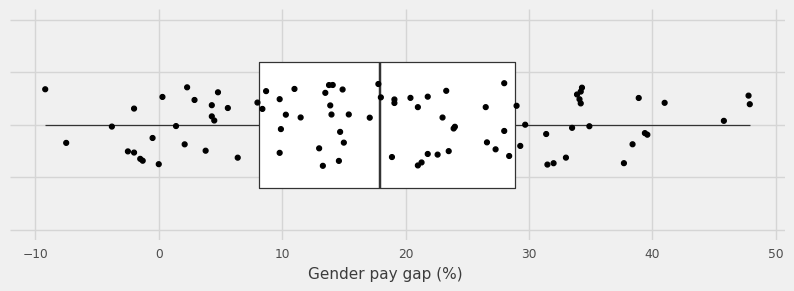

<ggplot: (8782528538778)>

In [75]:
# ggplot2 clone for python - any excuse to not have to use matplotlib!
import plotnine
from plotnine import ggplot, geom_boxplot, geom_jitter
from plotnine import aes, scale_x_continuous, coord_flip, theme, element_blank
from plotnine.themes import theme_set, theme_538

plotnine.options.figure_size = (10, 3)
theme_set(theme_538())

def plot_dist(df: pd.DataFrame, col: str) -> ggplot:
    """ Plot distribution of each indicator"""

    plot = (ggplot(df, aes(x = 0, y = col))
    + geom_boxplot(width = 1.2)
    + geom_jitter(width = 0.4, height=0)
    + scale_x_continuous(limits=(-1, 1))
    + coord_flip()
    + theme(axis_text_y=element_blank(), axis_title_y = element_blank())
    )
    
    return plot

# Save each indicator as a .png
for i in df.columns:
    # Try-except for empty columns - we'll deal with those later
    try:
        plot = plot_dist(df, i)
        plot.save(filename = f"graphics/{i}.png", height=3, width=10, verbose = False)

    except ValueError:
        pass

# Display example
plot_dist(df, "Gender pay gap (%)")

Level of WISE membership is binary


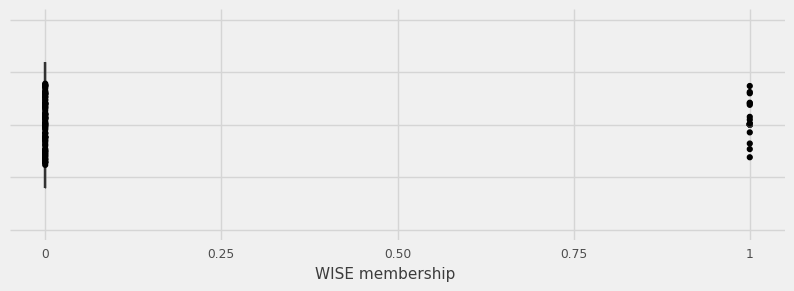

<ggplot: (8782529675825)>

In [76]:
print("WISE membership is binary")
plot_dist(df, "WISE membership")

Level of WISE membership is ordinal


/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 7 rows containing non-finite values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 7 rows containing missing values.


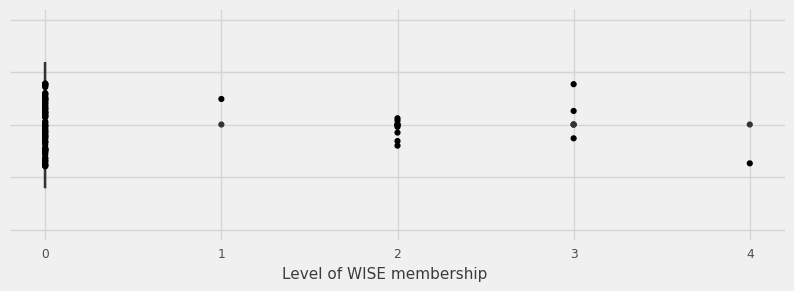

<ggplot: (8782528582428)>

In [77]:
print("Level of WISE membership is ordinal")
plot_dist(df, "Level of WISE membership")

Gender bonus pay gap has a long tail


/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 15 rows containing non-finite values.
/home/seitarowhite/miniconda3/envs/myenv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 15 rows containing missing values.


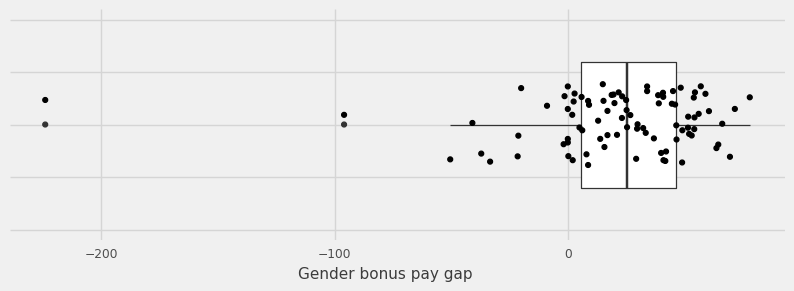

<ggplot: (8782529669870)>

In [78]:
print("Gender bonus pay gap has a long tail")
plot_dist(df, "Gender bonus pay gap")

# Missing Values
***

Let's take another look at those missing values (below)

<AxesSubplot:>

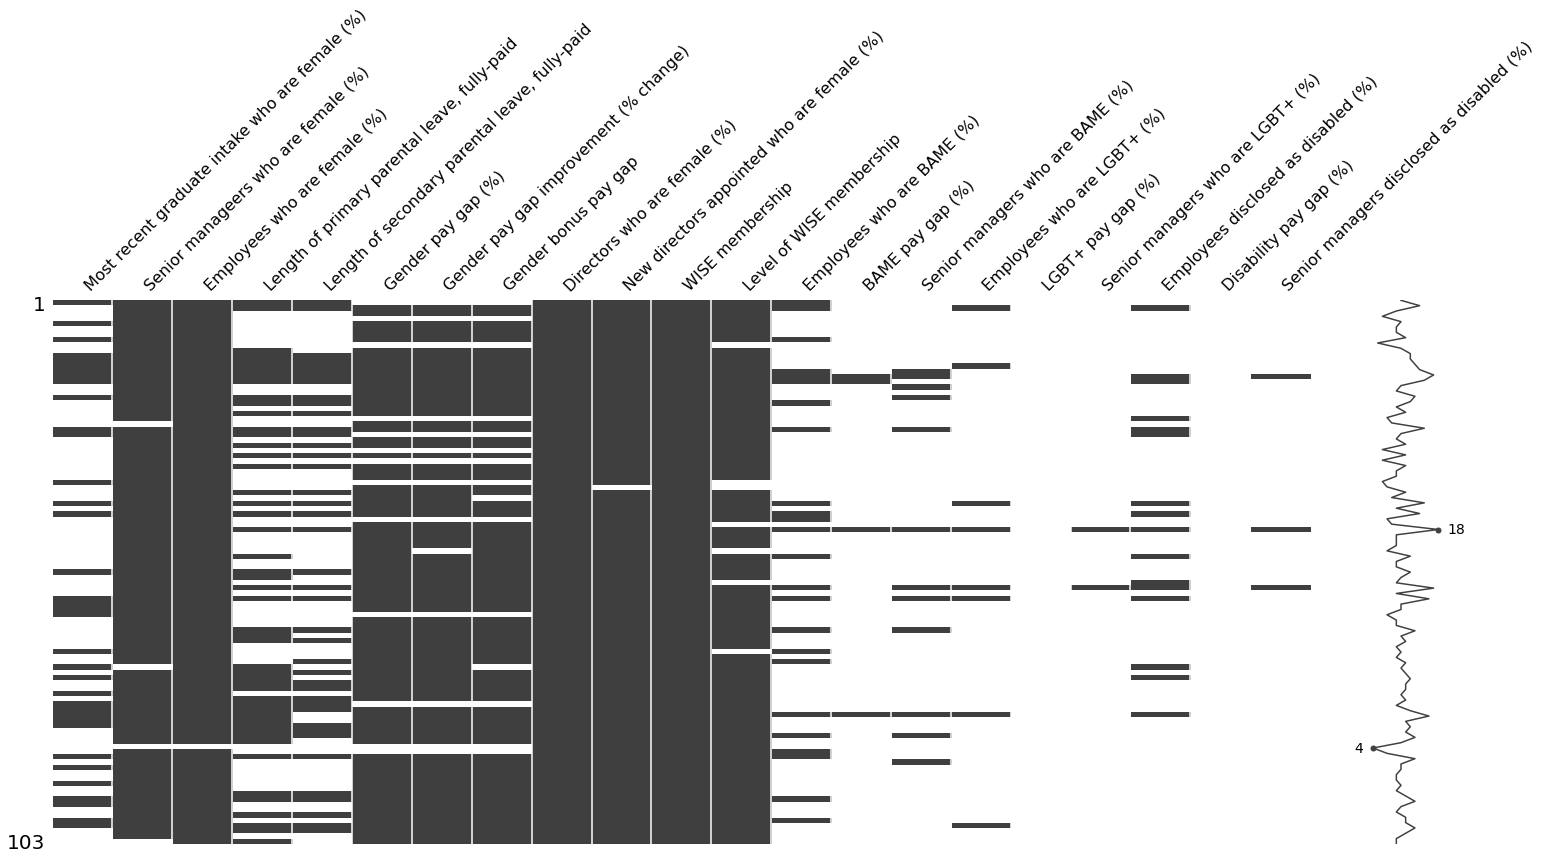

In [79]:
import missingno as msno
msno.matrix(df)

### **Imputation Approach**
The basic story is that we generally have pretty good data coverage for indicators related to Gender, but much sparser data for the other indicators, particularly those related to LGBT+ and Disability. Two indicators (LGBT+ and Disability Pay Gap) hold no data at all.

There are a number of different approaches we could take to deal with these missing values, ranging from the very simple (replacing gaps with 0 or the lowest scoring value available), to trying to populate missing values with an average taken from other companies for that indicator, to more complex methods that try to model/predict a missing value using existing data elsewhere (e.g. Linear models or clustering techniques)

For this project, I’ve keep things simple, and proceed on the basis of the following assumption, which is that ***missing datapoints represent a failure by the responsible company to report, and it is therefore fair to penalise those companies by imputing 0 or lowest-scoring values***. Missing data is a non-ignorable non-response

The inverse of this is perhaps clearer - it would be *unfair* to penalise Company A (which has reported a below-average value for a given indicator) in relation to Company B (which may have similarly poor performance but has failed to report) by imputing Company B an averaged value and therefore giving them a "benefit of the doubt" advantage. This could potentially incentivise poorly performing companies to deliberately withhold reporting if they knew that they would be "pulled up" by the average in the index.

Based on this, I’ve taken the following approaches (applying them to each indicator on a case-by-case basis):

- Imputation by Zero
- Imputation by worst relative value

In [221]:
# Implementation
impute_by_zero = [
    "Most recent graduate intake who are female (%)",
    "Senior manageers who are female (%)", 
    "Employees who are female (%)",
    "Gender pay gap improvement (% change)",
    "Directors who are female (%)",
    "New directors appointed who are female (%)",
    "Employees who are BAME (%)",
    "Employees who are LGBT+ (%)",
    "Senior managers who are LGBT+ (%)",
    "Senior managers who are BAME (%)",
    "Employees disclosed as disabled (%)",
    "Senior managers disclosed as disabled (%)"
]

impute_by_lowest = [
    "Length of primary parental leave, fully-paid",
    "Length of secondary parental leave, fully-paid", 
    "WISE membership",
    "Level of WISE membership",
]

impute_by_highest = [
    "Gender pay gap (%)",
    "Gender bonus pay gap",
    "BAME pay gap (%)"
]

df_imputed = df.copy(deep=True)

for i in impute_by_zero:
    df_imputed[i] = df_imputed[i].fillna(0)

for i in impute_by_lowest:
    df_imputed[i] = df_imputed[i].fillna(df_imputed[i].min())

for i in impute_by_highest:
    df_imputed[i] = df_imputed[i].fillna(df_imputed[i].max())

# Drop empty indicators
df_imputed = df_imputed.drop(columns=["LGBT+ pay gap (%)", "Disability pay gap (%)"])
df_imputed.head()

,Most recent graduate intake who are female (%),Senior manageers who are female (%),Employees who are female (%),"Length of primary parental leave, fully-paid","Length of secondary parental leave, fully-paid",Gender pay gap (%),Gender pay gap improvement (% change),Gender bonus pay gap,Directors who are female (%),New directors appointed who are female (%),WISE membership,Level of WISE membership,Employees who are BAME (%),BAME pay gap (%),Senior managers who are BAME (%),Employees who are LGBT+ (%),Senior managers who are LGBT+ (%),Employees disclosed as disabled (%),Senior managers disclosed as disabled (%)
Company,,,,,,,,,,,,,,,,,,,
3i,50.0,23.7,40.0,18.0,6.0,47.9,0.0,78.0,40.0,100.0,0,0.0,12.50,15.7,0.0,0.00,0.0,0.00,0.0
Admiral Group,0.0,34.0,51.0,16.0,2.0,4.5,-0.9,29.7,36.4,25.0,0,0.0,6.07,15.7,0.0,9.35,0.0,2.83,0.0
Anglo American plc,0.0,24.0,21.0,2.0,1.0,41.0,8.0,78.0,27.3,40.0,0,0.0,0.00,15.7,0.0,0.00,0.0,0.00,0.0
Antofagasta,0.0,21.0,10.0,2.0,1.0,47.9,0.0,78.0,20.0,0.0,0,0.0,0.00,15.7,0.0,0.00,0.0,0.00,0.0
Ashtead Group,14.0,13.8,9.6,2.0,1.0,-1.3,-0.4,-37.1,37.5,20.0,0,0.0,0.00,15.7,0.0,0.00,0.0,0.00,0.0


## **Normalisation**
*** 
I've simply normalising all indicators to a Min-Max scale of 0-1. The only other steps for some indicators taken were to:
- Invert indicators where a higher value is considered bad and vice versa
- Transform the "Gender Pay Bonus Gap (%)" indicator with the long tail

In [222]:
from scipy import stats


# Transform "Gender bonus pay gap"
# Add shift constant to make all values positive
shift = abs(df_imputed["Gender bonus pay gap"].min())
df_imputed["Gender bonus pay gap"] = df_imputed["Gender bonus pay gap"] + shift + 1

# Apply Box-Cox Transformation
df_imputed["Gender bonus pay gap"] = stats.boxcox(df_imputed["Gender bonus pay gap"])[0]


# Normalise data
def normalise(x: pd.Series) -> pd.Series:
    """ Normalise a series to a MinMax 0-1 scale """
    
    x_norm = [(i - x.min()) / (x.max() - x.min()) for i in x.values]
    return pd.Series(x_norm)
    

df_norm = df_imputed.copy(deep=True)

index = df_norm.index
df_norm = df_norm.apply(normalise, axis=0)
df_norm = df_norm.set_index(index)

# Invert indicators
inverse_indicators = [
    "Gender pay gap (%)",
    "Gender bonus pay gap",
    "BAME pay gap (%)"
]

for i in inverse_indicators:
    df_norm[i] = 1 - df_norm[i]

df_norm.head()

,Most recent graduate intake who are female (%),Senior manageers who are female (%),Employees who are female (%),"Length of primary parental leave, fully-paid","Length of secondary parental leave, fully-paid",Gender pay gap (%),Gender pay gap improvement (% change),Gender bonus pay gap,Directors who are female (%),New directors appointed who are female (%),WISE membership,Level of WISE membership,Employees who are BAME (%),BAME pay gap (%),Senior managers who are BAME (%),Employees who are LGBT+ (%),Senior managers who are LGBT+ (%),Employees disclosed as disabled (%),Senior managers disclosed as disabled (%)
Company,,,,,,,,,,,,,,,,,,,
3i,0.83,0.45,0.59,0.42,0.13,0.00,0.66,0.00,0.69,1.00,0.0,0.0,0.30,0.0,0.0,0.0,0.0,0.00,0.0
Admiral Group,0.00,0.64,0.75,0.37,0.03,0.76,0.62,0.33,0.62,0.25,0.0,0.0,0.14,0.0,0.0,1.0,0.0,0.29,0.0
Anglo American plc,0.00,0.45,0.31,0.00,0.00,0.12,1.00,0.00,0.47,0.40,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
Antofagasta,0.00,0.40,0.15,0.00,0.00,0.00,0.66,0.00,0.34,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
Ashtead Group,0.23,0.26,0.14,0.00,0.00,0.86,0.65,0.66,0.64,0.20,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0


## Weighting and Aggregation
***

In working out a weighting scheme for the indicators, I've broadly considered two different methodologies/frameworks.

1) The impact of weighting from a purely statistical sense - thinking about the data isolated from any external factors, how can we weight our indicators to get a result that is statistically sound

2) The impact of weighting in a wider social context - thinking about the index as something that will be made publicly available, used by others and iterated over time, what value judgements are we making about Gender/Race/LGBT+/Disability by assigning certain weighting schemes? How might our index affect company behaviour as they seek to improve their rankings?

### **Weighting by Relevance**

Weighting by Relevance is about considering how directly relevant indicators are to determining a company's performance on equality. For this small project, I will keep my approach to weighting very simple and use just two relevancy tiers - indicators that I consider to be "fully relevant" and those that I consider to be only "partially relevant". The majority of indicators will be taken as fully relevant and given an equal weighting, but I consider these indicators to be only partially relevant for the following reasons:

- **WISE membership** and **Level of WISE membership** - It's possible for Companies to join organisations like WISE as a window-dressing exercise. WISE is also focused on women-in-stem, which may not necessarily apply to every company on our list

- **Gender pay gap improvement (% change)** - Pay gay improvement is relative. Company A with a pay gap of 30% but an improvement of 7% is still worse comparatively than Company B with a pay gap of 2% but an improvement of 0.5%

I did also consider **Employees who are female (%)**, because this is not necessarily informative about the state of gender equality on a company on it's own. A company could have majority female employees but also have a large pay gap, and all its senior positions occupied by men. However, I decided that **Employees who are female (%)** was useful in the negative sense - while a high percentage does not necessarily indicate good gender equality around pay/power within a company, an unusually low value is a definite indicator that something is wrong!

For indicators deemed "fully relevant", a weighting of 1 will be assigned, while for indicators deemed "partially relevant", a weighting of 0.5 will be assigned

### **Weighting by Evidence**

Weighting by Evidence is about weighting indicators according to how complete the data is - an indicator with less missing values should be considered more reliable and weighted accordingly. Weighting by Evidence causes us all sorts of problems here because of the nature of our dataset, which is heavily imbalanced towards Gender - I'll provide two alternative approaches and discuss the benefits and draw backs of each to explain this

1) One approach would be to weight each indicator in direct proportion to the completeness of the reported data - for example, "Gender pay gap (%)" might be weighted at 0.87, and "BAME pay gap (%)" at just 0.03. This is attractive from a purely statistical point of view for obvious reasons. However in doing so, we are making an implicit value judgement about which factors matter for equality - since the majority of reported data we have is for Gender indicators, we are saying that Gender is therefore much more important than Race, LGBT+ or Disability in measuring equality within a company which is not necessarily a desirable outcome (to be precise for this dataset, Gender would make up 93.5% of the index) In addition, assigning low weight indicators with low reporting could lead to a vicious circle - if disability indicators are assigned very low weight because of the lack of data, companies seeking to improve their rank in future will have very little incentive to actually improve reporting around disability, meaning that in the next iteration reporting will be similarly poor and so on.

2) An alternative approach would be to ignore evidence entirely and simply consider each indicator equally regardless of reporting completeness. An even further step might be to take an "intersectional" approach and combine all indicators into 4 pillars for Gender/Race/LGBT+/Disability and weight each pillar equally as 25% of the index. The obvious problem here for our dataset is that we would end up with an index where 93.5% of the actual reported data ends up informing just 63% of the final rank, or only 25% with the intersectional approach, which seems to defeat the point of researching an index all together. 
    (An additional problem is that data collection/reporting on the different equality dimensions can't be treated as exactly identical -  LBGT+ and Disability particularly are sensitive areas where employees may feel unwilling or unable to disclose information about themselves for reasons both internal and external to a company)

For this project, I've decided to take a hybrid approach that represents a compromise between the two extremes - I'll treat relevancy and evidence as two entirely separate components of weighting for each indicator that are calculated separately and averaged at the end. Since as mentioned earlier relevancy is almost always equal, this will act as a baseline weighting for each indicator. For example, for the earlier example of Gender vs BAME pay gap:
- They are both assigned relevancy weight of 1
- They are assigned an evidence weight of 0.87 and 0.03 respectively
- Relevancy and Evidence weights are averaged (by mean)
- The total sum is 0.935 for Gender, and 0.515 BAME - the BAME pay gap is weighted lower due to lack of evidence, but not *so* much lower that it becomes insignificant

It should be acknowledged this compromise approach is less that ideal, but hopefully it does avoid the worse extremes of the 2 initial approaches explained above

In [226]:
# Show data reporting percentages for each indicator
# print(df.notna().sum() / 103 * 100)

# Show percentage of reported data that each "pillar" contributes to
total_reported_datapoints = df.notna().sum().sum()
print(f"Total Reported Datapoints: {total_reported_datapoints}")

print(f"Gender - {df.iloc[:, 0:12].notna().sum().sum() / total_reported_datapoints:.3f}")
print(f"BAME - {df.iloc[:, 12:15].notna().sum().sum() / total_reported_datapoints:.3f}")
print(f"LGBT+ - {df.iloc[:, 15:18].notna().sum().sum() / total_reported_datapoints:.3f}")
print(f"Disability - {df.iloc[:, 18:].notna().sum().sum() / total_reported_datapoints:.3f}")


Total Reported Datapoints: 1068
Gender - 0.935
BAME - 0.037
LGBT+ - 0.009
Disability - 0.018


In [228]:
indicators = df_norm.columns

# Relevancy weights
rel_wt = np.ones(df_norm.shape[1])

part_rel_indicators = [
    "Gender pay gap improvement (% change)",
    "WISE membership",
    "Level of WISE membership"
]

for ct, i in enumerate(indicators):
    if i in part_rel_indicators:
        rel_wt[ct] = 0.5

# Evidence weights
# Percentage of non-missing reported data for each indicator
evi_wt = np.array([df[i].notna().sum() / df[i].shape[0] for i in indicators])

# Combine evidence and relevancy weight components to single weight array
weights = (rel_wt + evi_wt) / 2

for ct, i in enumerate(indicators):
    print(f"{i} - {weights[ct]:.2f}")

# Apply weighting to normalised dataset
df_weighted = df_norm * weights
df_weighted.head()

Most recent graduate intake who are female (%) - 0.67
Senior manageers who are female (%) - 0.98
Employees who are female (%) - 1.00
Length of primary parental leave, fully-paid - 0.74
Length of secondary parental leave, fully-paid - 0.70
Gender pay gap (%) - 0.94
Gender pay gap improvement (% change) - 0.68
Gender bonus pay gap - 0.93
Directors who are female (%) - 1.00
New directors appointed who are female (%) - 1.00
WISE membership - 0.75
Level of WISE membership - 0.72
Employees who are BAME (%) - 0.62
BAME pay gap (%) - 0.52
Senior managers who are BAME (%) - 0.56
Employees who are LGBT+ (%) - 0.54
Senior managers who are LGBT+ (%) - 0.51
Employees disclosed as disabled (%) - 0.58
Senior managers disclosed as disabled (%) - 0.51


,Most recent graduate intake who are female (%),Senior manageers who are female (%),Employees who are female (%),"Length of primary parental leave, fully-paid","Length of secondary parental leave, fully-paid",Gender pay gap (%),Gender pay gap improvement (% change),Gender bonus pay gap,Directors who are female (%),New directors appointed who are female (%),WISE membership,Level of WISE membership,Employees who are BAME (%),BAME pay gap (%),Senior managers who are BAME (%),Employees who are LGBT+ (%),Senior managers who are LGBT+ (%),Employees disclosed as disabled (%),Senior managers disclosed as disabled (%)
Company,,,,,,,,,,,,,,,,,,,
3i,0.56,0.44,0.58,0.31,0.09,0.00,0.45,0.00,0.69,1.00,0.0,0.0,0.18,0.0,0.0,0.00,0.0,0.00,0.0
Admiral Group,0.00,0.63,0.74,0.27,0.02,0.71,0.43,0.30,0.62,0.25,0.0,0.0,0.09,0.0,0.0,0.54,0.0,0.17,0.0
Anglo American plc,0.00,0.44,0.31,0.00,0.00,0.11,0.68,0.00,0.47,0.40,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0
Antofagasta,0.00,0.39,0.15,0.00,0.00,0.00,0.45,0.00,0.34,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0
Ashtead Group,0.16,0.26,0.14,0.00,0.00,0.81,0.44,0.61,0.64,0.20,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0


# Final Results
***

In [229]:
# Generated indice
df_indice = pd.DataFrame(
    index = df_weighted.sum(axis=1).sort_values(ascending=False).index,
    columns = ["Total Score", "Rank"],
    data = np.vstack([
        df_weighted.sum(axis=1).sort_values(ascending=False).values,
        np.arange(1, df_weighted.shape[0]+1)]).T)

df_indice

,Total Score,Rank
Company,,
ITV plc,7.41,1.0
Lloyds Banking Group,6.68,2.0
GlaxoSmithKline,5.87,3.0
AstraZeneca,5.62,4.0
Royal Dutch Shell,5.62,5.0
Standard Life Aberdeen,5.57,6.0
BT Group,5.56,7.0
Severn Trent,5.51,8.0
Royal Bank of Scotland Group,5.46,9.0
